# Extremely narrowed project for people knowing nothing about Obi-Wan Kenobi

Let's imagine a crazy context.

You know nothing about star wars.

Yes, as I said, it's crazy. But imagine how boring it must be during parties when people bring topics such as the wise Obi-Wan Kenobi. You can't participate to the discussion.

Then, what can you do ?

Watch Star wars ? Too easy. Let's scrap wikipedia and do NLP.

(The wiki page is french)

# Import Data

Let's use the following code to retrieve a clean HTML Wikipedia page from a variable.

In [66]:
import requests
from bs4 import BeautifulSoup
r = requests.get("https://fr.wikipedia.org/wiki/Obi-Wan_Kenobi")
html_doc = r.text
soup = BeautifulSoup(html_doc, 'html.parser')
 
corpus = []
for p in soup.find_all("p"):
  corpus.append(p.text)

# Visualization of first element
corpus[:1]

["Si vous disposez d'ouvrages ou d'articles de référence ou si vous connaissez des sites web de qualité traitant du thème abordé ici, merci de compléter l'article en donnant les références utiles à sa vérifiabilité et en les liant à la section «\xa0Notes et références\xa0» \n"]

* We need to install `spacy` modules corresponding to the language specifics (in this case French)


In [67]:
!python -m spacy download fr_core_news_sm -q

[+] Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [68]:
# Import spacy and initialize french language
import fr_core_news_sm
nlp = fr_core_news_sm.load()

# Corpus

For the rest, we need to create a complete and clean corpus of text in a variable.

In [69]:
# Stripped corpus of text
stripped_corpus = [text.strip() for text in corpus]

# Join corpus to make one full string
join_corpus = " ".join(stripped_corpus)

# Decode text 
clean_corpus = join_corpus.strip().encode("utf-8").decode("utf-8")

# Remove punctuation with string 
import string
clean_corpus = clean_corpus.translate(str.maketrans('', '', string.punctuation))

# Visualize first 16 characters
print("{}...".format(clean_corpus[:16]))

Si vous disposez...


Now we load the clean corpus in a `doc` object.

In [70]:
doc = nlp(clean_corpus)

Let's see what brings the first word cloud 

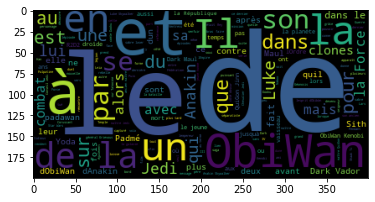

In [71]:
# Import wordcloud and matplotlib
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Instanciate wordcloud
wd = WordCloud()

# Generate wordcloud 
cloud = wd.generate(doc.text)

# Show plot
plt.imshow(cloud)
plt.show()

As expected, we have too many useless words to interpret anything.

Let's remove them using stop-words

In [72]:
# Import Stop words 
from spacy.lang.fr.stop_words import STOP_WORDS

# Visualize first 10 words
for i, word in enumerate(STOP_WORDS):
    if i < 10:
        print(word)
    else:
         break

possibles
quelles
celui-là
relative
eu
puisque
elles-mêmes
avant
auxquelles
tous


Now, how does the wordcloud looks like ?

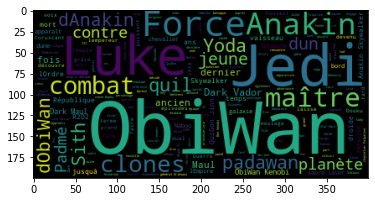

In [73]:
# Import wordcloud and matplotlib
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Instanciate wordcloud
wd = WordCloud(stopwords=STOP_WORDS)

# Generate wordcloud 
cloud = wd.generate(doc.text)

# Show plot
plt.imshow(cloud)
plt.show()

This is way better but we can do more with lemmatization !

(Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.)

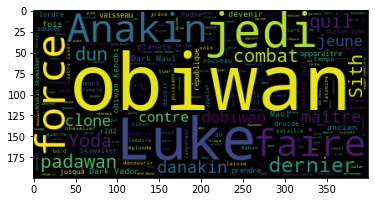

In [74]:
# Create lemmatization 
lemma = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS]

# Create a new corpus 
corpus_lemma = " ".join(lemma)

# Create a word cloud 
wd = WordCloud(stopwords=STOP_WORDS)

# Generate wordcloud
cloud = wd.generate(corpus_lemma)

# Visualize wordcloud 
plt.imshow(cloud)
plt.show()

We can push it even further and find what are the common words in our corpus.

In [75]:
# Import pandas to create a series
import pandas as pd 

# Create a DataFrame of lemmatized token
lemmadf = pd.Series(lemma)

# Create a mask of all counted values greater than 22
common = lemmadf.value_counts()>22

# Apply mask
common = common[common]

#Visualize first ten terms 
common[:10]

obiwan    True
          True
Luke      True
jedi      True
Anakin    True
force     True
dtype: bool

Now we update our list of stop words with the common words

In [76]:
# Update stop words 
new_stop_words = common.index

# Create a union of sets 
STOP_WORDS_updated = STOP_WORDS.union(new_stop_words)

And we create a new word cloud 

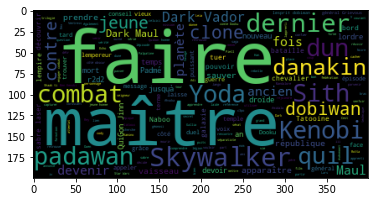

In [77]:
# Create a word cloud 
wd = WordCloud(stopwords=STOP_WORDS_updated)

# Generate wordcloud
cloud = wd.generate(corpus_lemma)

# Visualize wordcloud 
plt.imshow(cloud)
plt.show()

We will now start building a tf-idf matrix. Let's first create a DataFrame containing our lemmatized corpus without the updated stop words.

In [78]:
# Create lemmatization 
lemma = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS_updated]

# Create a new corpus 
corpus_lemma = " ".join(lemma)

# Create a Series with 1 document
corpus_series = pd.Series(corpus_lemma)

# Include Series in a DataFrame for simpler manipulations 
corpus_df = pd.DataFrame(corpus_series, columns=["documents"])
corpus_df

,documents
0,disposer douvrage darticle référence connaître...


Let's create now a TF-IDF matrix using `sklearn`

In [79]:
# Tfidf transformer 
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
X = vectorizer.fit_transform(corpus_df['documents'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

array([[0.01029889, 0.01029889, 0.01029889, ..., 0.01029889, 0.03089666,
        0.01029889]])

Let's visualize most important words using `plotly`


In [80]:
# Creating a DataFrame with all the words and tf-idf score 
tfid_df = pd.DataFrame(dense, 
                        columns=[x for x in vectorizer.get_feature_names()])

tfid_df

,19,200,2004,2014,2016,25,26,30,39,44,...,élément,émerger,épaule,épique,épisode,équipe,étouffe,étudier,évènement,événement
0,0.010299,0.010299,0.010299,0.010299,0.010299,0.010299,0.010299,0.010299,0.010299,0.010299,...,0.010299,0.010299,0.010299,0.030897,0.051494,0.010299,0.010299,0.010299,0.030897,0.010299


In [81]:
# Transpose dataframe
tfid_df = tfid_df.T

# Create a new token column 
tfid_df["token"] = tfid_df.index

tfid_df

,0,token
19,0.010299,19
200,0.010299,200
2004,0.010299,2004
2014,0.010299,2014
2016,0.010299,2016
...,...,...
équipe,0.010299,équipe
étouffe,0.010299,étouffe
étudier,0.010299,étudier
évènement,0.030897,évènement


In [82]:
# Sort the top 15 values by descending order
tfid_df.sort_values(by=0, ascending=False)[:15]

,0,token
dark,0.226575,dark
faire,0.226575,faire
maul,0.185380,maul
maître,0.185380,maître
dobiwan,0.164782,dobiwan
kenobi,0.154483,kenobi
combat,0.154483,combat
skywalker,0.144184,skywalker
jeune,0.144184,jeune
dernier,0.133886,dernier


In [83]:
# Import plotly express
import plotly.express as px

# Create bar chart
fig = px.bar(tfid_df.sort_values(by=0, ascending=False)[:30], x="token", y=0)

# Render chart
fig.show(renderer="iframe")

If you wanted to get a broad idea of what Obi-wan is, you now have the most useful words of its wikipage. 